In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import constant
import tools

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from yellowbrick.cluster.elbow import kelbow_visualizer

# Load Data

In [11]:
windmill = pd.read_csv(constant.windmill_LW_600_path)

In [12]:
df = windmill[["GSRN", "Turbine_type", "Placement", "UTM_x", "UTM_y", "Capacity_kw", "Rotor_diameter", "Navhub_height", "grid", "Slope", "Elevation", "Roughness"]]
df = df[~df["UTM_x"].isnull()][~df["UTM_y"].isnull()][df["grid"] != 0]
df["Slope"] = df["Slope"].replace(-1, 0)
df["Elevation"] = df["Elevation"].replace(-1, 0)
df["Roughness"] = df["Roughness"].replace(-1, 0)
df = df[~df["Turbine_type"].isin(["H","M"])]
cols = df.columns

In [13]:
len(df)

552

In [14]:
encoder_cols = ["Rotor_diameter"]
ohe = OneHotEncoder(handle_unknown='ignore')

In [15]:
temp = pd.DataFrame(ohe.fit_transform(df[encoder_cols]).toarray())

In [16]:
dp_cols = ["Slope", "Elevation", "Roughness"]
temp = pd.merge(temp, df[dp_cols], left_index=True, right_index=True)

In [17]:
temp = StandardScaler().fit_transform(temp)

In [23]:
transformer = PCA(n_components=15)
transformer.fit(temp)
ratio = transformer.explained_variance_ratio_

In [24]:
def top_x():
        sum_v = 0
        for i, v in enumerate(ratio):
            sum_v += v
            # if features contains 95% info
            if sum_v > 0.90:
                return i + 1
        print("Set n > current n")
        return 0

top_x()

14

In [26]:
transformer = PCA(n_components=14)
X_transformed = transformer.fit_transform(temp)
ratio = transformer.explained_variance_ratio_

In [27]:
top_x()

14

In [22]:
temp = pd.DataFrame(X_transformed)

In [23]:
temp = pd.merge(df[["GSRN","grid","Navhub_height", "Roughness"]], temp, left_index=True, right_index=True)

In [24]:
temp.to_csv("data/windmill_test.csv")

In [ ]:
windmill_LP = windmill[windmill["Placement"] == "LAND"][windmill["Turbine_type"] == "P"].reset_index()[cols]
len(windmill_LP)

In [ ]:
windmill_HW = windmill[windmill["Placement"] == "HAV"][windmill["Turbine_type"] == "W"].dropna().reset_index()[cols]
len(windmill_HW)

In [ ]:
windmill_HP = windmill[windmill["Placement"] == "HAV"][windmill["Turbine_type"] == "W"].reset_index()[cols]
len(windmill_HP)

# Geo Impact Analysis

# SpectralClustering
## Clustering of windmills without Geodata

In [5]:
def SpectralClustering_elbow(df,k=(2,10)):
    df = StandardScaler().fit_transform(df)
    # Instantiate the clustering model and visualizer
    kelbow_visualizer(SpectralClustering(random_state=3, assign_labels='discretize'), df, k=k)

In [6]:
def SpectralClustering_simple(df, k):
    df = StandardScaler().fit_transform(df)
    # Instantiate the clustering model and visualizer
    sc = SpectralClustering(random_state=3, assign_labels='discretize', n_clusters=k)
    cluster = sc.fit_predict(df)
    return cluster

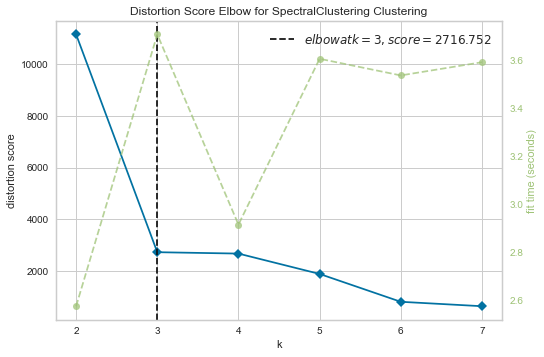

In [7]:
feat_cols = ["Capacity_kw", "Rotor_diameter", "Navhub_height"]
windmill_c = windmill_LW[feat_cols]
SpectralClustering_elbow(windmill_c,(2,8))

In [8]:
cluster = SpectralClustering_simple(windmill_c, 3)
windmill_LW["wm_cluster"] = pd.Series(cluster)
windmill_LW.groupby("wm_cluster")["wm_cluster"].count()

wm_cluster
0    3194
1       8
2     704
Name: wm_cluster, dtype: int64

In [ ]:
windmill_c = windmill_HW[feat_cols]
windmill_c = StandardScaler().fit_transform(windmill_c)
windmill_c[:,0] =  windmill_c[:,0] * 3
windmill_c[:,1] =  windmill_c[:,1] * 2
windmill_c[:,2] =  windmill_c[:,2] * 2
SpectralClustering_elbow(windmill_c,(2,7))

In [ ]:
cluster = SpectralClustering_simple(windmill_c, 4)
windmill_HW["wm_cluster"] = pd.Series(cluster)
windmill_HW.groupby("wm_cluster")["wm_cluster"].count()

In [ ]:
feat_cols = ["Capacity_kw"]
windmill_c = windmill_LP[feat_cols]
windmill_c = StandardScaler().fit_transform(windmill_c)
windmill_c =  windmill_c * 3
SpectralClustering_elbow(windmill_c, (2,7))

In [ ]:
cluster = SpectralClustering_simple(windmill_c, 5)
windmill_LP["wm_cluster"] = pd.Series(cluster)
windmill_LP.groupby("wm_cluster")["wm_cluster"].count()

In [ ]:
windmill_c = windmill_HP[feat_cols]
windmill_c = StandardScaler().fit_transform(windmill_c)
windmill_c =  windmill_c * 3
SpectralClustering_elbow(windmill_c)

In [ ]:
cluster = SpectralClustering_simple(windmill_c, 3)
windmill_HP["wm_cluster"] = pd.Series(cluster)
windmill_HP.groupby("wm_cluster")["wm_cluster"].count()

## Clustering of windmills with Geodata

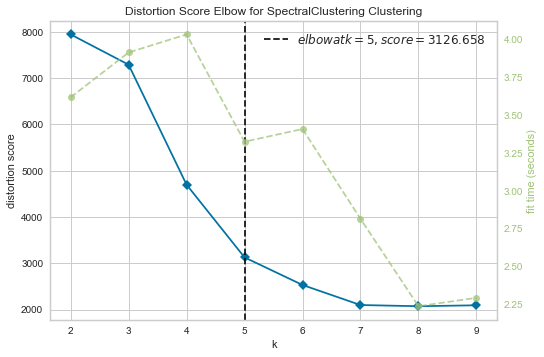

In [9]:
feat_cols = ["Roughness", "Slope", "Elevation"]
windmill_c = windmill_LW[feat_cols]
SpectralClustering_elbow(windmill_c)

In [10]:
cluster = SpectralClustering_simple(windmill_c, 5)
windmill_LW["geo_cluster"] = pd.Series(cluster)
windmill_LW.groupby("geo_cluster")["geo_cluster"].count()

geo_cluster
0    1649
1     920
2    1307
3      21
4       9
Name: geo_cluster, dtype: int64

In [11]:
windmill_LW["agg_cluster"] = windmill_LW["wm_cluster"].astype(str) + windmill_LW["geo_cluster"].astype(str)

In [ ]:
windmill_c = windmill_HW[feat_cols]
windmill_c = StandardScaler().fit_transform(windmill_c)
SpectralClustering_elbow(windmill_c,(2,10))

In [ ]:
cluster = SpectralClustering_simple(windmill_c, 3)
windmill_HW["geo_cluster"] = pd.Series(cluster)
windmill_HW.groupby("geo_cluster")["geo_cluster"].count()

In [ ]:
windmill_HW["agg_cluster"] = windmill_HW["wm_cluster"].astype(str) + windmill_HW["geo_cluster"].astype(str)

In [ ]:
windmill_c = windmill_LP[feat_cols]
windmill_c = StandardScaler().fit_transform(windmill_c)
SpectralClustering_elbow(windmill_c, (2,14))

In [ ]:
cluster = SpectralClustering_simple(windmill_c, 7)
windmill_LP["geo_cluster"] = pd.Series(cluster)
windmill_LP.groupby("geo_cluster")["geo_cluster"].count()

In [ ]:
windmill_LP["agg_cluster"] = windmill_LP["wm_cluster"].astype(str) + windmill_LP["geo_cluster"].astype(str)

In [ ]:
windmill_LP.groupby(["agg_cluster"])["GSRN"].count()

In [ ]:
windmill_c = windmill_HP[feat_cols]
windmill_c = StandardScaler().fit_transform(windmill_c)
SpectralClustering_elbow(windmill_c)

In [ ]:
cluster = SpectralClustering_simple(windmill_c, 3)
windmill_HP["geo_cluster"] = pd.Series(cluster)
windmill_HP.groupby("geo_cluster")["geo_cluster"].count()

In [ ]:
windmill_HP["agg_cluster"] = windmill_HP["wm_cluster"].astype(str) + windmill_HP["geo_cluster"].astype(str)

In [ ]:
windmill_HP.groupby(["agg_cluster"])["GSRN"].count()

# Meanshift
## Without Geo

In [ ]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
def meanshift_silhouette(df):
    df = StandardScaler().fit_transform(df)
    sc = MeanShift()
    clusters = sc.fit_predict(df)
    silhouette_avg = silhouette_score(df, clusters)
    print(silhouette_avg, len(np.unique(clusters)))
    return clusters

In [ ]:
feat_cols = ["Capacity_kw", "Rotor_diameter", "Navhub_height"]
windmill_c = windmill_LW[feat_cols]
meanshift_silhouette(windmill_c)

In [ ]:
windmill_c = windmill_HW[feat_cols]
meanshift_silhouette(windmill_c)

In [ ]:
feat_cols = ["Capacity_kw"]
windmill_c = windmill_LP[feat_cols]
meanshift_silhouette(windmill_c)

In [ ]:
windmill_c = windmill_HP[feat_cols]
meanshift_silhouette(windmill_c)

## With Geo

In [ ]:
feat_cols = ["Capacity_kw", "Rotor_diameter", "Navhub_height", "Roughness", "Slope"]
windmill_c = windmill_LW[feat_cols]
clusters = meanshift_silhouette(windmill_c)

In [ ]:
windmill_c["Cluster"] = pd.Series(clusters)

In [ ]:
windmill_c.groupby("Cluster")["Cluster"].count()

In [ ]:
windmill_c = windmill_HW[feat_cols]
meanshift_silhouette(windmill_c)

In [ ]:
feat_cols = ["Capacity_kw", "Roughness", "Slope"]
windmill_c = windmill_LP[feat_cols]
meanshift_silhouette(windmill_c)

In [ ]:
windmill_c = windmill_HP[feat_cols]
meanshift_silhouette(windmill_c)

### Without Slope

In [ ]:
feat_cols = ["Capacity_kw", "Rotor_diameter", "Navhub_height", "Roughness"]
windmill_c = windmill_LW[feat_cols]
meanshift_silhouette(windmill_c)

In [ ]:
windmill_c = windmill_HW[feat_cols]
meanshift_silhouette(windmill_c)

In [ ]:
feat_cols = ["Capacity_kw", "Roughness"]
windmill_c = windmill_LP[feat_cols]
meanshift_silhouette(windmill_c)

In [ ]:
windmill_c = windmill_HP[feat_cols]
meanshift_silhouette(windmill_c)

# SpectralClustering
## Without

In [ ]:
windmill_pd = windmill.toPandas()

In [ ]:
windmill_pd.head(3)

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height"]
windmill_pd1 = windmill_pd[feat_cols]
windmill_pd1 = StandardScaler().fit_transform(windmill_pd1)

for k in range(5,15):
    sc = SpectralClustering(n_clusters=k,random_state=1,n_init=10)
    clusters = sc.fit_predict(windmill_pd1)

    silhouette_avg = silhouette_score(windmill_pd1, clusters)
    print(k, silhouette_avg)

# SpectralClustering
## With

In [ ]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "roughness"]
windmill_pd1 = windmill_pd[feat_cols]
windmill_pd1 = StandardScaler().fit_transform(windmill_pd1)

for k in range(5,15):
    sc = SpectralClustering(n_clusters=k,random_state=1,n_init=10)
    clusters = sc.fit_predict(windmill_pd1)

    silhouette_avg = silhouette_score(windmill_pd1, clusters)
    print(k, silhouette_avg)